In [ ]:
pip install tensorflow numpy pandas matplotlib opencv-python scikit-learn

In [ ]:
import tensorflow as tf
print(f"TensorFlow: {tf.__version__}")
#check ver

TensorFlow: 2.18.0


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Train.tar to Train.tar


In [ ]:
#extract tar file
import tarfile
import os

# Create a folder to extract dataset
os.makedirs("trainSet", exist_ok=True)

# Extract Train.tar
with tarfile.open("Train.tar") as tar:
    tar.extractall(path="trainSet")

# Verify class folders inside Train (should be 0 to 42)
print("Folders:", os.listdir("trainSet"))


Folders: ['8', '21', '11', '15', '26', '12', '10', '16', '33', '18', '32', '6', '22', '30', '7', '5', '39', '35', '2', '17', '38', '36', '41', '19', '25', '40', '31', '13', '3', '29', '0', '24', '27', '20', '37', '9', '23', '1', '14', '28', '4', '34', '42']


In [ ]:
import shutil
import random
import os

# Define the base split folder
base_split_path = "GTSRB"

# Clean (delete) old train/val/test folders if they exist
for split in ['train', 'val', 'test']:
    split_path = os.path.join(base_split_path, split)
    if os.path.exists(split_path):
        shutil.rmtree(split_path)  # Delete the entire folder and its contents
        print(f"🧹 Removed existing folder: {split_path}")


# Create new folders for split data
os.makedirs("GTSRB/train", exist_ok=True)
os.makedirs("GTSRB/val", exist_ok=True)
os.makedirs("GTSRB/test", exist_ok=True)

# Ratios for splitting
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Loop through each class folder (0 to 42)
for class_name in os.listdir("trainSet"):
    class_path = os.path.join("trainSet", class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    random.shuffle(images)

    n_total = len(images)
    n_train = int(train_ratio * n_total)
    n_val = int(val_ratio * n_total)

    # Make class folders
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join("GTSRB", split, class_name), exist_ok=True)
   # Copy files to corresponding split folders
    for i, img in enumerate(images):
        src = os.path.join(class_path, img)
        if i < n_train:
            dst = os.path.join("GTSRB/train", class_name, img)
        elif i < n_train + n_val:
            dst = os.path.join("GTSRB/val", class_name, img)
        else:
            dst = os.path.join("GTSRB/test", class_name, img)

        shutil.copyfile(src, dst)

print("✅ train/val/test split done.")

# Check sorted folders in each split
for split in ['train', 'val', 'test']:
  print(f"\n📁 {split.upper()} folders:")
  for class_folder in sorted(os.listdir(f"GTSRB/{split}")):
     print(class_folder)



🧹 Removed existing folder: GTSRB/train
🧹 Removed existing folder: GTSRB/val
🧹 Removed existing folder: GTSRB/test
✅ train/val/test split done.

📁 TRAIN folders:
0
1
10
11
12
13
14
15
16
17
18
19
2
20
21
22
23
24
25
26
27
28
29
3
30
31
32
33
34
35
36
37
38
39
4
40
41
42
5
6
7
8
9

📁 VAL folders:
0
1
10
11
12
13
14
15
16
17
18
19
2
20
21
22
23
24
25
26
27
28
29
3
30
31
32
33
34
35
36
37
38
39
4
40
41
42
5
6
7
8
9

📁 TEST folders:
0
1
10
11
12
13
14
15
16
17
18
19
2
20
21
22
23
24
25
26
27
28
29
3
30
31
32
33
34
35
36
37
38
39
4
40
41
42
5
6
7
8
9


In [ ]:
#this cell is use to import library-jessy22/5
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping




In [ ]:
#Preprocess the Images
# Path to training directory,validation directory,testing directory
train_dir = "GTSRB/train"
val_dir = "GTSRB/val"
test_dir = "GTSRB/test"

# Image parameters
img_height, img_width = 64, 64 #i set 64*64 pixel so the image not loose too many detail need try n error -jessy22/5
batch_size = 32 #large batch then fasttrain but maybe worse generalization,small batch slow training but better generalization Common values: 16, 32, 64, 128., need try n error-jessy22/5

# Create ImageDataGenerator for rescaling
datagen = ImageDataGenerator(rescale=1./255)# normalize 0-255 to 0-1, faster

# Training data
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,# Number of images per training step
    class_mode='categorical',# Use one-hot encoding for class labels
    shuffle=True# randomly shuffles the order of the training images every epoch.Prevents the model from learning the order of data
)

# Validation data
val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',

)

#Test data (for final evaluation)
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)



Found 27439 images belonging to 43 classes.
Found 5872 images belonging to 43 classes.
Found 5898 images belonging to 43 classes.


In [ ]:
#build cnn
num_classes = 43  # Traffic signs from class 0 to 42

#hidden layer use relu because Fast, good for images,can learn non-linear feature
model = Sequential([
    # first convolutional layer
    Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 3)),#Conv2D(32, (3,3) Extracts 32(32 is the number of filters aka pattern detectors) low-level features from the image,higher the filter ,more feature can learn
    MaxPooling2D(2,2),#	Reduces image size while keeping key features
    # second convolutional
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # 3rd convolutional
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),#Convert the 2D feature maps into a 1D vector.Because the upcoming Dense (fully connected) layer only accepts 1D input.

    #4th layer
    Dense(128, activation='relu'),#A fully connected layer with 128 neurons.
    #128 neurons that learn combinations of features.
    #ReLU activation allows the model to learn nonlinear decision boundaries, like "if there's a red border AND octagonal shape → might be a stop sign."
    #Role: Feature Combination / Decision Making
    #Where: Before the final output layer

    Dropout(0.5),# layer randomly drops 50% of the neurons during training.Helps prevent overfitting

    #5th layer
    Dense(num_classes, activation='softmax')
    #(softmax) the model to output 43 probabilities (one for each class).The highest probability will be the predicted class.
    #Picks the best class (highest probability) as prediction
    #Role: Final Classification Layer
    #Where: Last layer of the model
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Show model structure
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 688,747 (2.63 MB)

 Trainable params: 688,747 (2.63 MB)

 Non-trainable params: 0 (0.00 B)

total we have 10 layers include the "tools" use to reduce img size like max_pooling


but for trainable layers we only have 5 [mean if the layer with neuron is 5 layers only]

1.Conv2D is a layer used in Convolutional Neural Networks (CNNs)

-Automatically extracts features (like edges, corners, shapes) from 2D images.

-Applies small filters (also called kernels) that slide over the image to detect patterns.

In [ ]:
# Define EarlyStopping callback — stop training if val_loss doesn't improve for 3 consecutive epochs
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    train_generator,
    epochs=30,  # Use higher max epochs; early stopping will halt it early if needed
    validation_data=val_generator,
    callbacks=[early_stop]  # apply early stopping based on validation loss
)

# Evaluate final model accuracy on test data (untouched during training/validation)
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")



Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


858/858 ━━━━━━━━━━━━━━━━━━━━ 221s 255ms/step - accuracy: 0.3314 - loss: 2.4557 - val_accuracy: 0.9174 - val_loss: 0.2886
Epoch 2/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 219s 255ms/step - accuracy: 0.8416 - loss: 0.4999 - val_accuracy: 0.9818 - val_loss: 0.1018
Epoch 3/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 209s 244ms/step - accuracy: 0.9125 - loss: 0.2608 - val_accuracy: 0.9888 - val_loss: 0.0567
Epoch 4/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 274s 258ms/step - accuracy: 0.9399 - loss: 0.1826 - val_accuracy: 0.9857 - val_loss: 0.0672
Epoch 5/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 213s 249ms/step - accuracy: 0.9531 - loss: 0.1407 - val_accuracy: 0.9937 - val_loss: 0.0364
Epoch 6/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 210s 245ms/step - accuracy: 0.9590 - loss: 0.1226 - val_accuracy: 0.9951 - val_loss: 0.0305
Epoch 7/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 210s 245ms/step - accuracy: 0.9673 - loss: 0.0972 - val_accuracy: 0.9942 - val_loss: 0.0368
Epoch 8/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 210s 245ms/step - accuracy: 0.9755 - loss: 0.07

note from jc:

GTSRB/train is split from train data set for training

GTSRB/val split from train data set for early storpping ,and monitor overfitting or not
(if val accurary low than train accuracy maybe overfitting)

GTSB/test split from train data set for whole model testing with 15% unseen data,just see how well it can predict



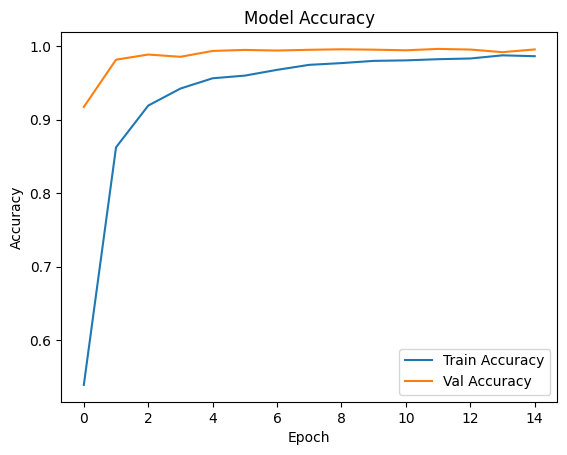

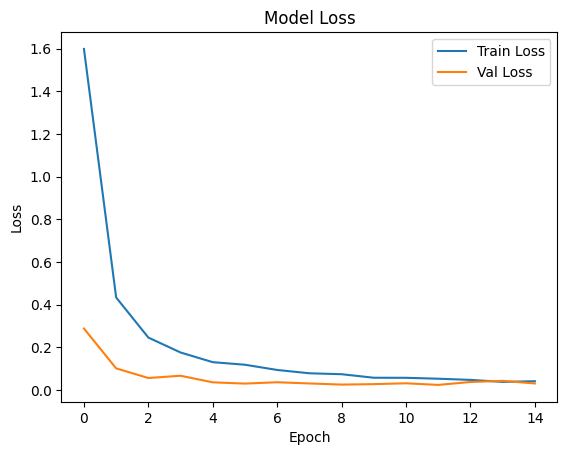

In [ ]:
# Plot Training vs Validation Accuracy/Loss
#note here is validation accuracy not test acuracy because validation data is the data use ib training for evry epoch
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


185/185 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step


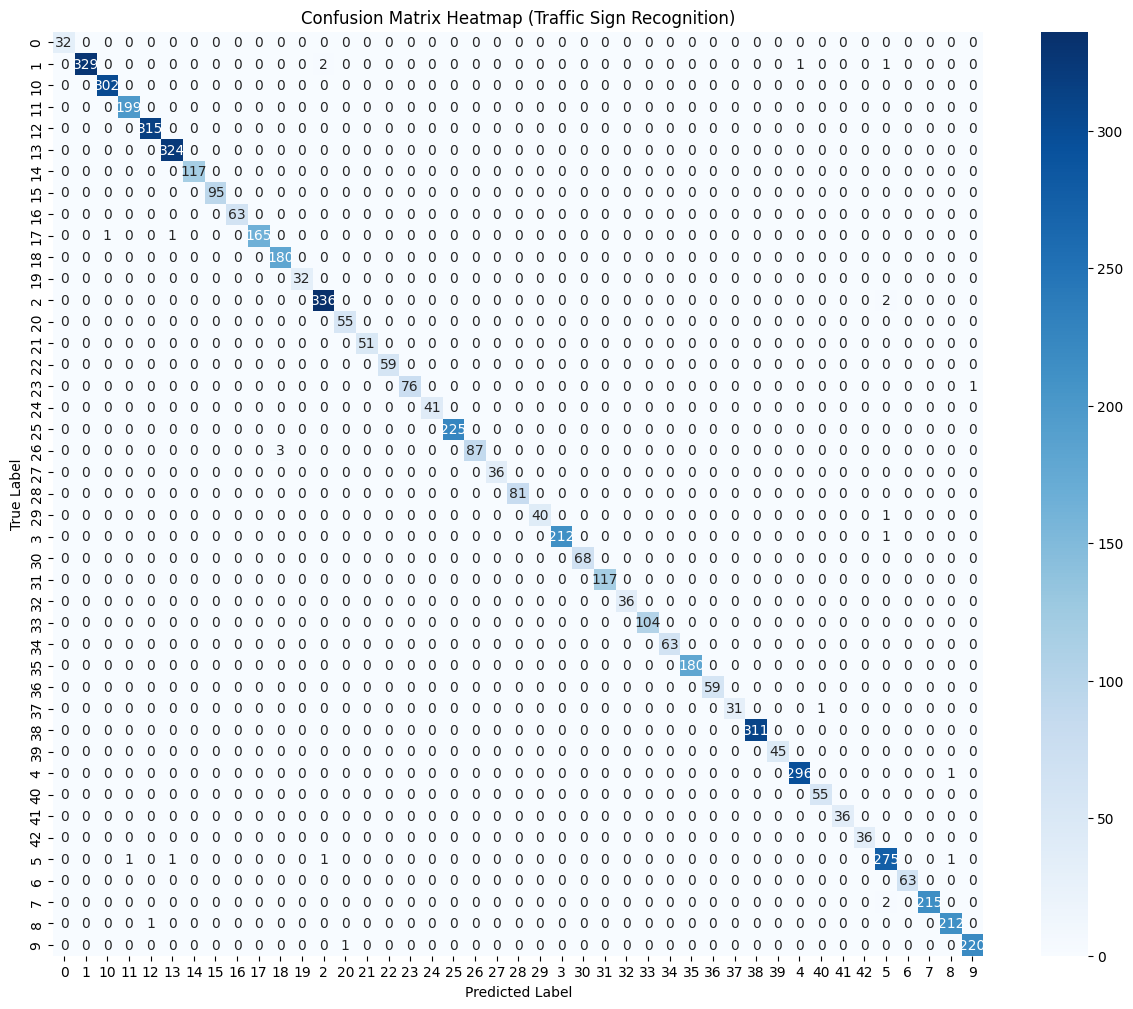

In [ ]:
#confusion matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report


# Step 1: Get true and predicted labels from the test set
y_true = test_generator.classes  # actual labels
y_pred_probs = model.predict(test_generator)  # predicted probabilities
# Convert probabilities to predicted class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# Step 2: Create confusion matrix
cm = confusion_matrix(y_true, y_pred)


# Step 3: Create DataFrame with class names as labels
labels = list(test_generator.class_indices.keys())  # class label names
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Stp 4: Plot heatmap
# Class labels (0 to 42 for GTSRB)
class_labels = list(test_generator.class_indices.keys())

# Set figure size
plt.figure(figsize=(15, 12))

# Create the heatmap using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)

# Axis labeling
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap (Traffic Sign Recognition)')
plt.show()


In [ ]:
# Save to an HDF5 file (standard format)
model.save('traffic_sign_cnn_model.h5')


Saving 00006.png to 00006.png
User uploaded file "00006.png"
Image shape after resize: (64, 64)
Image array shape: (64, 64, 3)
Pixel value range: min=0.058823529411764705, max=1.0
Shape after adding batch dimension: (1, 64, 64, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


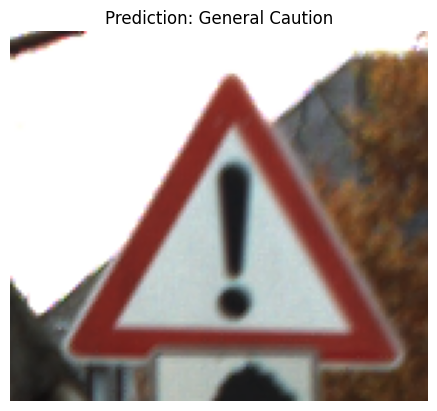

In [ ]:
from tensorflow.keras.models import load_model
from google.colab import files
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load your saved model (adjust filename/path if needed)
model = load_model('traffic_sign_cnn_model.h5')

# Map class indices to names (update this dict with your full labels)
idx_to_class = {
0: 'Speed Limit (20 km/h)',
    1: 'Speed Limit (30 km/h)',
    2: 'No Passing for Vehicles Over 3.5 Metric Tons',
    3:  'Right-Of-Way at the next intersection',
    4: 'Priority Road',
    5: 'Yield',
    6: 'Stop',
    7: 'No Vehicles',
    8: 'Vehicles Over 3.5 Metric Tons Prohibited',
    9: 'No Entry',
    10: 'General Caution',
    11: 'Dangerous Curve To the Left',
    12: 'Speed Limit (50 km/h)',
    13: 'Dangerous Curve To the Right',
    14: 'Double Curve',
    15: 'Bumpy Road',
    16: 'Slippery Road',
    17: 'Road Narrows On The Right',
    18 : 'Road Work',
    19:  'Traffic Signals',
    20: 'Pedestrians',
    21 : 'Children Crossing',
    22:  'Bicycles Crossing',
    23: 'Speed Limit (60 km/h)',
    24: 'Beware of Ice/Snow',
    25: 'Wild Animals Crossing',
    26: 'End of All Speed and Passing Limits',
    27: 'Turn Right Ahead',
    28: 'Turn Left Ahead',
    29: 'Ahead Only',
    30:'Go Straight Or Right',
    31: 'Go Straight Or Left',
    32: 'Keep Right',
    33: 'Keep Left',
    34:'Speed Limit (70 km/h)',
    35: 'Roundabout Mandatory',
    36: 'End Of No Passing',
    37: 'End Of No Passing by Vehicles over 3.5 Metric Tons',
    38: 'Speed Limit (80 km/h)',
    39: 'End of Speed Limit (80 km/h)',
    40: 'Speed Limit (100 km/h)',
    41:  'Speed Limit (120 km/h)',
    42: 'No Passing',

}
IMG_SIZE = (64, 64)  # model input size

def preprocess_image(img_path):
    img = Image.open(img_path).convert('RGB')
    img = img.resize(IMG_SIZE)
    img_array = np.array(img) / 255.0

    print(f"Image shape after resize: {img.size}")  # should be (64, 64)
    print(f"Image array shape: {img_array.shape}")  # should be (64,64,3)
    print(f"Pixel value range: min={img_array.min()}, max={img_array.max()}")

    img_array = np.expand_dims(img_array, axis=0)  # add batch dimension
    print(f"Shape after adding batch dimension: {img_array.shape}")  # (1,64,64,3)

    return img_array
# Upload image from local device
uploaded = files.upload()

for fn in uploaded.keys():
    print(f'User uploaded file "{fn}"')

    # Preprocess and predict
    img_array = preprocess_image(fn)
    pred_probs = model.predict(img_array)
    pred_class = np.argmax(pred_probs, axis=1)[0]
    pred_name = idx_to_class.get(pred_class, "Unknown")

    # Display image
    img = Image.open(fn)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Prediction: {pred_name}')
    plt.show()


---------------------jc's part end here-----------------
